In [2]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../fbportal_updated.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [4]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions: ","",newString)
    newString = re.sub(r"precondition: ","",newString)
    newString = re.sub(r"[^a-zA-Z0-9]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString

In [5]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)

In [8]:
data['embediing_trf']=list(embeddings_trs)

In [9]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.007616806, 0.005843046, 0.11240678, 0.050339803, 0.0025280218, 0.05087099, -0.008886891, -0.036157727, -0.08662188, 0.0311569, 0.01335425, -0.052121345, -0.08929149, -0.041871995, -0.033586346,..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.061214644, -0.036375344, 0.017356947, 0.11064824, 0.034364067, 0.00844421, -0.02982958, 0.049617253, -0.008215632, -0.014838813, -0.05537365, 0.016051913, -0.07240089, 0.04741791, 0.013640383,..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.009730592, 0.053419113, 0.114213474, 0.08534335, -0.002091682, -0.017286636, 0.0074873674, -0.06525991, -0.013874467, 0.0016921184, -0.036969494, -0.05427648, 0.018393617, -0.028270843, 0.0616..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.010006898, -0.03475733, 0.08833386, -0.013573887, 0.11943102, -0.011142135, 0.029939154, -0.078966804, -0.011841778, 0.02961379, -0.06445307, -0.016232042, 0.0030896598, 0.061305318, -0.0309999..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.045031086, 0.05021305, 0.08135207, 0.08382549, 0.07056706, -0.014506235, -0.047058668, -0.00294058, -0.09286142, -0.05570672, -0.048554104, -0.11892631, 0.049603164, 0.03901029, 0.014843174, -..."


In [10]:
data['Label'].value_counts()

Device       101
Timer         47
Calling       43
Weather       35
Alarm         28
Time          26
Corona        21
Integrity     16
Name: Label, dtype: int64

In [11]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.cleaned_text).toarray()
labels = data.Label
features.shape




(317, 44)

In [12]:
from sklearn.feature_selection import chi2
import numpy as np
index= data.index
category_id_df = data[['Label', pd.Series(index.values)]].drop_duplicates().sort_values('Label')
category_to_id = dict(category_id_df.values)


N = 2
for Product, category_id in sorted(category_to_id.items()):
    

    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

TypeError: unhashable type: 'Series'

### Multicalss classification prediction by using MultinomialNB and tfidf vectorizer

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['Label'], test_size=0.33,random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf_NB = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred_NB = clf_NB.predict(count_vect.transform(X_test))

In [17]:

print(clf_NB.predict(count_vect.transform(["turn on the microphone"])))

['Device']


In [15]:
X_test

134                           set a timer for 3
250                               dim my screen
55                              show all alarms
255                                     go home
308                      turn on the microphone
                         ...                   
54                    set snooze for 20 minutes
206        what s the latest on the coronavirus
284                                open spotify
289    please increase the brightness some more
223                     darken the screen by 1 
Name: cleaned_text, Length: 105, dtype: object

In [16]:
y_test

134     Timer
250    Device
55      Alarm
255    Device
308    Device
        ...  
54      Alarm
206    Corona
284    Device
289    Device
223    Device
Name: Label, Length: 105, dtype: object

### Model Selection 

In [18]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

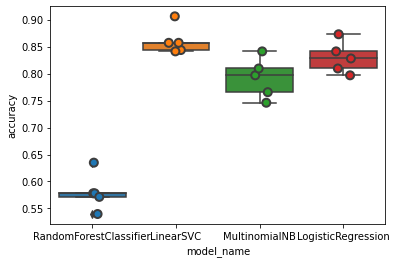

In [19]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

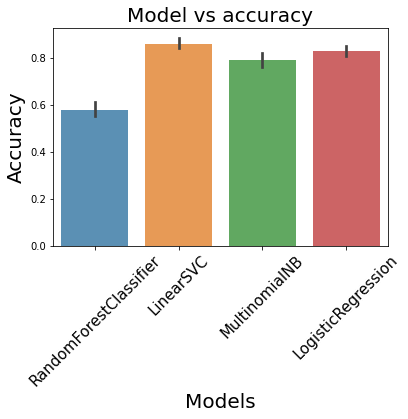

In [20]:
#plt.figure(figsize=(20,15))
sns.barplot(cv_df.model_name, cv_df.accuracy, alpha=0.8)
plt.title("Model vs accuracy", fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.yticks(fontsize=10)
plt.xlabel('Models', fontsize=20)
plt.xticks(fontsize=15,rotation=45)
plt.show()

In [21]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.861111
LogisticRegression        0.829762
MultinomialNB             0.791865
RandomForestClassifier    0.580456
Name: accuracy, dtype: float64

### Visualizing ROC curve for MultinomialNB

In [31]:
from yellowbrick.classifier import ROCAUC

In [ ]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'functional', 
                                        1: 'needs repair', 
                                        2: 'nonfunctional'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

### Applying LinearSVC model, since it is giving good accuracy score.

In [37]:
features[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.75041243, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.66096988, 0.        ])

In [25]:
model_svc = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_train_tfidf, labels, df.index, test_size=0.33, random_state=0)
model_svc.fit(X_train_tfidf, y_train)

y_pred_svc = model_svc.predict(count_vect.transform(X_test))
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score
conf_mat = confusion_matrix(y_test, y_pred_svc)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=data.Label.values, yticklabels=data.Label.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()
print(conf_mat)


[[ 5  0  0  3  0  0  1  0]
 [ 0 12  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  1]
 [ 0  1  0  0  5  0  0  0]
 [ 0  0  0  0  0  6  0  1]
 [ 0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0  0 14]]


In [70]:
X_test[0:10]

181      make a call with robinson blake
258                get screen brightness
15     whats the weather in minneapolis 
65                                  time
216                     coronavirus news
63            how late is it in istanbul
240                      set volume at 1
228           bring up brightness by 20 
167                        call ross gay
156                             call ira
Name: cleaned_text, dtype: object

In [69]:
y_pred[0:10]

array(['Calling', 'Device', 'Weather', 'Time', 'Corona', 'Weather',
       'Device', 'Device', 'Calling', 'Calling'], dtype=object)

In [68]:
y_test[0:10]

181    Calling
258     Device
15     Weather
65        Time
216     Corona
63        Time
240     Device
228     Device
167    Calling
156    Calling
Name: Label, dtype: object

In [71]:
print(model.predict(count_vect.transform(["how late is it in istanbul"])))

['Weather']


In [72]:
print(clf.predict(count_vect.transform(["how late is it in istanbul"])))

['Time']


### Saving the model

In [77]:
import pickle
import joblib

In [81]:
joblib.dump(clf, 'Classification/model/nb_model.pkl')

['Classification/model/nb_model.pkl']

In [82]:
nb_clf = joblib.load('Classification/model/nb_model.pkl')
 
# Use the loaded model to make predictions
print(nb_clf.predict(count_vect.transform(["how late is it in istanbul"])))

['Time']


### Testing the model

In [28]:
def Missclassification(X_test,y_test,y_pred):
    df = pd.DataFrame(X_test)
    df['Actual_label'] = y_test
    df['Predicted_label'] = y_pred
    df_val=pd.DataFrame(df['Actual_label'].value_counts())
    print(df['Actual_label'].value_counts())
    print(df['Predicted_label'].value_counts())
    df_val['Predicted_label_count'] = df['Predicted_label'].value_counts()
    df_val.rename(columns = {'Actual_label':'Actual_label_count'}, inplace = True)
    df_val['Misclassified'] = abs(df_val['Actual_label_count']-df_val['Predicted_label_count'])
    return df_val.sort_index()

In [29]:
df_svc= Missclassification(X_test,y_test,y_pred_svc)
df_svc

Device       34
Timer        16
Weather      14
Calling      12
Alarm         9
Time          7
Corona        7
Integrity     6
Name: Actual_label, dtype: int64
Device       36
Timer        17
Weather      16
Calling      13
Corona        7
Time          6
Integrity     5
Alarm         5
Name: Predicted_label, dtype: int64


,Actual_label_count,Predicted_label_count,Misclassified
Alarm,9,5,4
Calling,12,13,1
Corona,7,7,0
Device,34,36,2
Integrity,6,5,1
Time,7,6,1
Timer,16,17,1
Weather,14,16,2


In [27]:
df_NB=Missclassification(X_test,y_test,y_pred_NB)
df_NB

,Actual_label_count,Predicted_label_count,Misclassified
Alarm,9,4,5
Calling,12,13,1
Corona,7,5,2
Device,34,38,4
Integrity,6,2,4
Time,7,8,1
Timer,16,20,4
Weather,14,15,1
